In [1]:
from __future__ import division, print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

In [2]:
from sm_funcs import get_spectral_type
import sm_funcs


We have to simulation the stars and the planets that orbit those stars, so first we are going to make up a population of stars.

The first thing to do is to get all the stars observed by Kepler, we can get this from the MAST.
Then load the masses and then assign a one or fewer binary companions. Binary distributions is Raghavan et al. 2010.



In [127]:
keplerstellar = pd.read_csv('../data/kepler_stellar17.csv.gz', delimiter='|')
allquarters = keplerstellar.st_quarters == 11111111111111111
isGoodData = np.isfinite(keplerstellar.mass) & (keplerstellar.st_radius < 3.5)

In [128]:
# we want interpolate a relationship between temperate and absolute magnitude

mamajek = pd.read_table('../data/EEM_dwarf_UBVIJHK_colors_Teff.txt', 
                        skiprows=20, delim_whitespace=True, skipfooter=440,
                        engine='python', na_values=['...','....','.....'])
mamajek.columns = [c.replace('-', '_') for c in mamajek.columns]


mamajek.loc[:,'Mr'] =   - mamajek.loc[:,'Mv'] - mamajek.loc[:,'V_Rc']



In [129]:
# from Raghavan et al. 2010

# orbital period distribution
logPeriod = np.random.normal(5.03,2.28, size=keplerstellar.shape[0])

#for OBAFMKMLT
binaryProbability = {'O': 0.75, 
                      'B': 0.70, 
                      'A': 0.70, 
                      'F': 0.50,
                      'G': 0.41,
                      'K': 0.41,
                      'M': 0.35,
                      'L': 0.20,
                      'T': 0.20,
                      }

# mass ratio can be approximated by a uniform
# but it may be better estimated by distribution that increases toward higher number
# so I'll use uniform in (e - e^(x)) / (e - 1)
massRatio = (np.e-np.e**(np.random.uniform(size=keplerstellar.shape[0]))) / (np.e-1.0)
mp = keplerstellar.loc[:,'mass'].copy()
compMass = mp * massRatio

# we need to companion mass to be in the stellar range, so > 0.08
while np.any(compMass < 0.08):
    nSmall = np.shape(compMass[compMass < 0.08])[0]
    massRatio[compMass < 0.08] = (np.e-np.e**(np.random.uniform(size=nSmall))) / (np.e-1.0)
    compMass[compMass < 0.08] = mp[compMass < 0.08] * massRatio[compMass < 0.08]


Now we need to go through the catalog and assign a binary companion

In [130]:
# let's make some new columns that we'll need

stype_arr = np.empty(keplerstellar.shape[0], dtype='str')
isBinary_arr = np.empty(keplerstellar.shape[0], dtype='bool')

for idx in tqdm(range(keplerstellar.shape[0])):
    stype = get_spectral_type(keplerstellar['teff'][idx])
    stype_arr[idx] = stype
    isBinary_arr[idx] = binaryProbability[stype]  <  np.random.uniform()




100%|██████████| 200038/200038 [00:06<00:00, 30357.08it/s]


In [131]:
# which star should the planet orbit
# we'll say it's 50/50 unless the companion is an M-dwarf
# let's say that the max mass of an M-dwarf is 0.55 Msun
# and let's say that if it's an M-dwarf, the probability the planet's around a companion is 2.5/0.689

orbitProb = np.where(compMass<=0.55, 1. - (0.689/2.5), 0.5)
orbitProb[~isBinary_arr] = 0.0
orbitsPrimary = np.where(np.random.uniform(size=keplerstellar.shape[0]) > orbitProb, True, False)


In [132]:
# it's a factor of a few hundred times faster to loop and add to the dataframe
keplerstellar.loc[:,'stype'] = stype_arr
keplerstellar.loc[:,'isBinary'] = isBinary_arr
keplerstellar.loc[:,'massRatio'] = massRatio
keplerstellar.loc[:,'period'] = np.e**logPeriod
keplerstellar.loc[:,'compMass'] = compMass
keplerstellar.loc[:,'orbitsPrimary'] = orbitsPrimary
keplerstellar.loc[:,'hostMass'] = np.where(orbitsPrimary, 
                                     keplerstellar.mass, compMass)


In [133]:
# now let's make an array that excludes things we don't want
q = keplerstellar.loc[allquarters & isGoodData,:]

OK, now we need to start putting planets around these stars. We're going to use Fressin's catalog for all stars except M-dwarfs and use Dressing's number for M-dwarfs. 

For the time being we are going to make the assumption that every star has a planet

In [134]:
#some parameters we will need later

# let's make them all transit for now
# q.loc[:,'cosi'] = pd.Series(np.random.random(size=q.shape[0]),name='cosi')

q.loc[:,'noise_level'] = sm_funcs.kepler_noise_6h(q.loc[:,'kepmag']) * np.sqrt(6)


In [135]:
# add planets
# first draw planets

mdwarfplanets = sm_funcs.Dressing15_select(q.shape[0])
otherplanets = sm_funcs.Fressin13_select(q.shape[0])

# then assign either a planet from Fressin or Dressing
[planetRadius, planetPeriod] = np.where(q.loc[:,'hostMass'] < 0.55, mdwarfplanets, otherplanets )



In [136]:
m = np.isfinite(mamajek.loc[:,'Mr']) & np.isfinite(mamajek.loc[:,'Msun'])

Mr_primary = np.interp(q.loc[:,'mass'],
                       mamajek.loc[:,'Msun'][m][::-1], mamajek.loc[:,'Mr'][m][::-1], np.nan, np.nan)
Mr_companion = np.interp(q.loc[:,'compMass'],
                       mamajek.loc[:,'Msun'][m][::-1], mamajek.loc[:,'Mr'][m][::-1], np.nan, np.nan)

# we need to get a radius for the companion
mamajekRadius = np.sqrt(10**mamajek.loc[:,'logL'][m] / (mamajek.loc[:,'Teff'][m]**4 / 5778.**4))
compRadius = np.interp(q.loc[:,'compMass'],
                       mamajek.loc[:,'Msun'][m][::-1], mamajekRadius[::-1], np.nan, np.nan)
q.loc[:,'compRadius'] = compRadius
q.loc[:,'hostRadius'] = np.where(q.loc[:,'orbitsPrimary'], q.loc[:,'st_radius'], q.loc[:,'compRadius'])

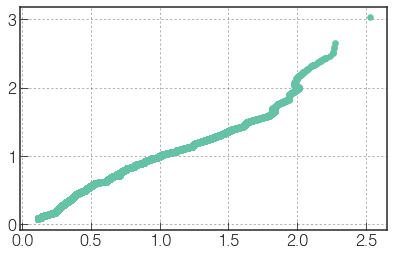

In [137]:
plt.scatter(q.loc[:,'compRadius'], q.loc[:,'compMass'])
plt.grid()

In [138]:
q.loc[:,'planetRadius'] = planetRadius
q.loc[:,'planetPeriod'] = planetPeriod
q.loc[:,'rprs'] = sm_funcs.get_rprs(planetRadius, q.loc[:,'hostRadius'])
q.loc[:, 'ars'] = sm_funcs.per2ars(planetPeriod, q.loc[:,'hostMass'], 
                                   q.loc[:,'hostRadius'])

# need a fudge here to stop a/r* < 1
q.loc[:, 'ars'] = np.where(q.loc[:, 'ars'] < 1.0, 1.01, q.loc[:, 'ars'])

q.loc[:, 'duration'] = sm_funcs.get_duration(planetPeriod, q.loc[:,'ars'], rprs=q.loc[:,'rprs'])

In [139]:
q.loc[:,'duration_correction'] = np.sqrt(q.loc[:,'duration'] * 24.) # correction for CDPP because transit dur != 1 hour
q.loc[:,'transit_depth_undiluted']  = sm_funcs.get_transit_depth(q.loc[:,'planetRadius'], 
                                                                 q.loc[:,'hostRadius']) * 1.E-6


In [140]:
# we need to go from undiluted transit depth to diluted transit depth
# so we have deltaF / F1 and we want deltaF/(F1+F2)

# we should do this calculation in magnitude
# so take the kepmag and estimate the kepmag for a companion

q.loc[:,'transit_depth_diluted'] = 0.
q.ix[~q.isBinary, 'transit_depth_diluted']  = q.loc[:,'transit_depth_undiluted' ]
q.ix[q.isBinary & q.orbitsPrimary, 'transit_depth_diluted'] = q.loc[:,'transit_depth_undiluted'] / (
    1+10**((Mr_primary - Mr_companion) / -2.5))
q.ix[q.isBinary & ~q.orbitsPrimary, 'transit_depth_diluted'] =  q.transit_depth_undiluted / (
    1+10**((Mr_companion - Mr_primary) / -2.5))


# should be every star
assert( (q.ix[~q.isBinary, 'transit_depth_diluted'].shape[0] + 
 q.ix[q.isBinary & q.orbitsPrimary, 'transit_depth_diluted'].shape[0] + 
 q.ix[q.isBinary & ~q.orbitsPrimary, 'transit_depth_diluted'].shape[0]) == q['transit_depth_diluted'].shape[0])

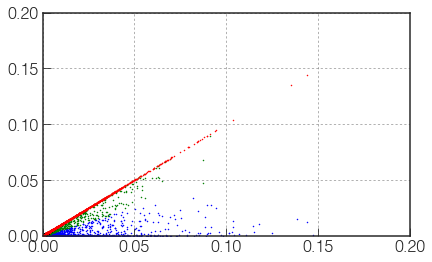

In [141]:

# binary, orbits companion
plt.scatter(q.transit_depth_undiluted[q.isBinary & ~q.orbitsPrimary] , 
            q.transit_depth_diluted[q.isBinary & ~q.orbitsPrimary], 
            c='blue', s=1)

# binary, orbits primary
plt.scatter(q.transit_depth_undiluted[q.isBinary & q.orbitsPrimary] , 
            q.transit_depth_diluted[q.isBinary & q.orbitsPrimary], 
            c='green', s=1)
# single star
plt.scatter(q.transit_depth_undiluted[~q.isBinary], 
            q.transit_depth_diluted[~q.isBinary], 
            c='red', s=1)

plt.xlim(0,0.2)
plt.ylim(0,0.2)
plt.grid()

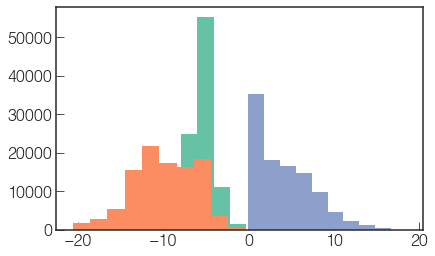

In [142]:
z = plt.hist(Mr_primary, )
z = plt.hist(Mr_companion, )
z = plt.hist(Mr_primary - Mr_companion, )

In [143]:
# finally, we need to build a detection model
# the detection can be a simple SNR threshold, let's pick 8 sigma
# so the probability of detection is if
# SNR > 8
# SNR = sqrt(ntransits) * duration_correction * transit_depth / noise
keplerduration = 4.0 * 365.
ntransits = np.around(keplerduration / q.planetPeriod )
sigma_threshold = 8.0

needed_for_detection_diluted = (q.transit_depth_diluted * 1.E6 * q.duration_correction *
                    np.sqrt(ntransits)) / sigma_threshold
detected_diluted = q.noise_level < needed_for_detection_diluted

needed_for_detection_undiluted = (q.transit_depth_undiluted * 1.E6 * q.duration_correction *
                    np.sqrt(ntransits)) / sigma_threshold
detected_undiluted = q.noise_level < needed_for_detection_undiluted

In [189]:
print(np.nonzero(detected_diluted)[0].shape)
print(np.nonzero(detected_undiluted[q.orbitsPrimary])[0].shape)

print(np.nonzero(detected_diluted & ~q.orbitsPrimary)[0].shape)

(67438,)
(59829,)
(8679,)


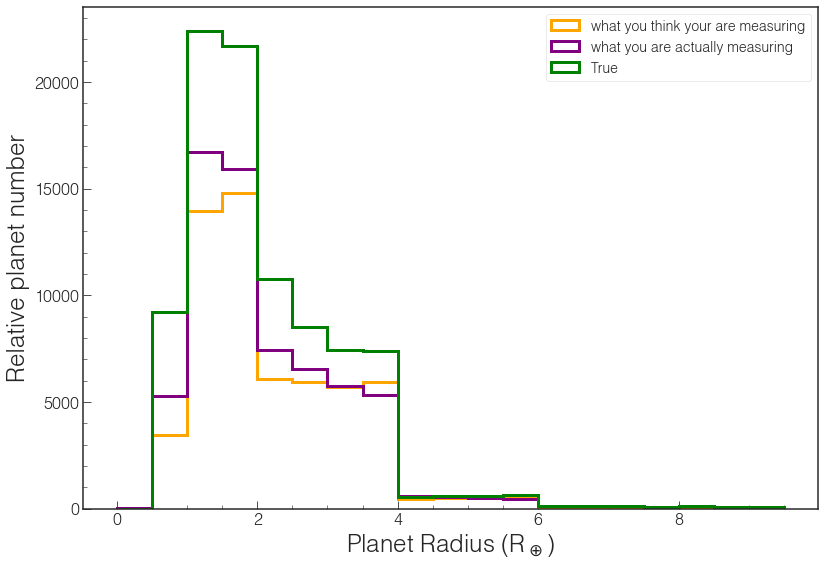

In [145]:


fig = plt.figure(figsize=[12,9])


plt.hist(np.sqrt(q.transit_depth_undiluted)[detected_undiluted][q.orbitsPrimary] * 
         q.hostRadius[detected_undiluted][q.orbitsPrimary] / 0.009155, 
         bins=np.arange(0,10,0.5),
         histtype='step', lw=3, color='orange',#, normed=True
         label='what you think your are measuring',
        )
plt.hist(np.sqrt(q.transit_depth_diluted)[detected_diluted] * q.st_radius[detected_diluted] / 0.009155, 
         bins=np.arange(0,10,0.5), 
         histtype='step', lw=3, color='purple',#, normed=True
         label='what you are actually measuring',
        )

plt.hist(np.sqrt(q.transit_depth_undiluted)[detected_undiluted] * q.hostRadius[detected_undiluted] / 0.009155, 
         bins=np.arange(0,10,0.5), 
         histtype='step', lw=3, color='green',#, normed=True
         label='True',
        )

plt.legend()
plt.xlabel('Planet Radius (R$_\oplus$)')
plt.ylabel('Relative planet number')

plt.minorticks_on()

(array([  3468.,  28747.,  12004.,  11665.,    970.,    994.,    194.,
           176.,    163.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 1 Patch objects>)

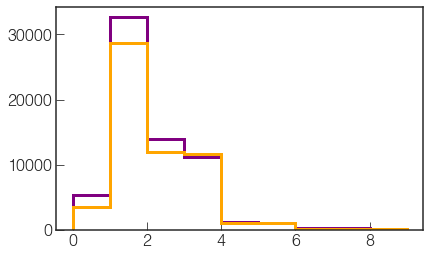

In [146]:
plt.hist(np.sqrt(q.transit_depth_diluted)[detected_diluted] * q.st_radius[detected_diluted] / 0.009155, 
         bins=np.arange(0,10,1), 
         histtype='step', lw=3, color='purple',#, normed=True
         label='including binaries',
        )
plt.hist(np.sqrt(q.transit_depth_undiluted)[detected_undiluted][q.orbitsPrimary] * 
         q.hostRadius[detected_undiluted][q.orbitsPrimary] / 0.009155, 
         bins=np.arange(0,10,1),
         histtype='step', lw=3, color='orange',#, normed=True
         label='no binaries',
        )

(0, 0.5)

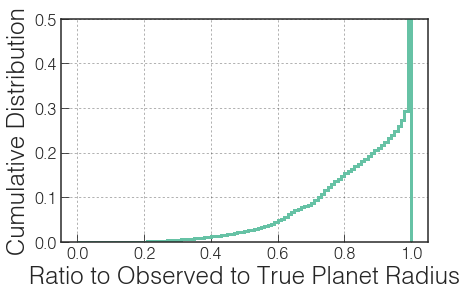

In [149]:
o1 = np.sqrt(q.transit_depth_diluted)[detected_diluted] * q.st_radius[detected_diluted] / 0.009155
o2 = np.sqrt(q.transit_depth_undiluted)[detected_diluted] * q.hostRadius[detected_diluted] / 0.009155

plt.hist((o1/o2), histtype='step',  cumulative=True, bins=np.arange(0,1.01,0.01), normed=True, lw=3)
plt.grid()
plt.xlabel('Ratio to Observed to True Planet Radius')
plt.ylabel('Cumulative Distribution')

plt.ylim(0,0.5)

(array([  7.40780000e+04,   1.36560000e+04,   2.50500000e+03,
          9.71000000e+02,   5.69000000e+02,   2.69000000e+02,
          1.14000000e+02,   4.90000000e+01,   1.50000000e+01,
          6.00000000e+00]),
 array([ 0.00230783,  0.0404821 ,  0.07865636,  0.11683062,  0.15500488,
         0.19317914,  0.2313534 ,  0.26952767,  0.30770193,  0.34587619,
         0.38405045]),
 <a list of 1 Patch objects>)

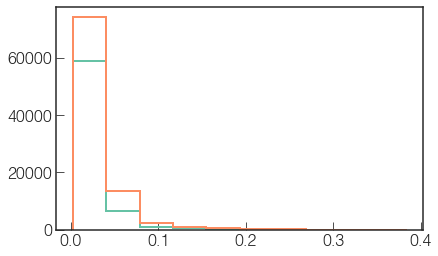

In [150]:
plt.hist(np.sqrt(q.transit_depth_undiluted)[detected_diluted], histtype='step', lw=2)
plt.hist(np.sqrt(q.transit_depth_undiluted)[detected_undiluted], histtype='step', lw=2)

In [151]:
q.transit_depth_undiluted[0:10]#[detected_undiluted][q.orbitsPrimary][0:10]

0     0.001058
1     0.004050
3     0.000053
4     0.001205
5     0.000190
6     0.002236
9     0.000310
10    0.000300
11    0.000829
12    0.000072
Name: transit_depth_undiluted, dtype: float64

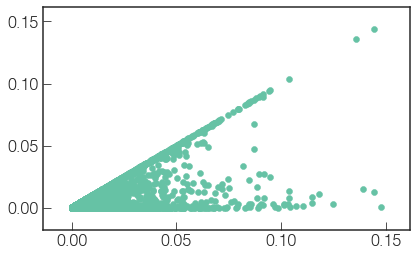

In [152]:
plt.scatter(q.transit_depth_undiluted, q.transit_depth_diluted)


(array([  9473.,  31008.,  14000.,   7901.,   2171.,    745.,    371.,
           195.,    196.,    174.,    172.,    152.,    135.,    107.,
            97.,     86.,    100.,     89.,     72.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 1 Patch objects>)

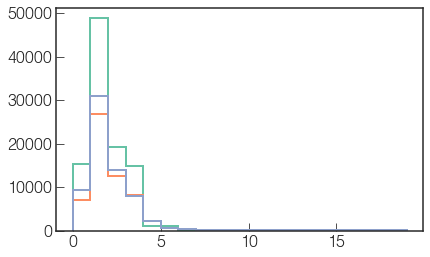

In [153]:
plt.hist(q.planetRadius, bins=np.arange(0,20,1), histtype='step', lw=2)

plt.hist(np.sqrt(q.transit_depth_undiluted)[detected_undiluted][q.orbitsPrimary] * q.hostMass[detected_undiluted][q.orbitsPrimary] / 0.009155,
        bins=np.arange(0,20,1), histtype='step', lw=2 )

plt.hist(np.sqrt(q.transit_depth_diluted)[detected_diluted] * q.mass[detected_diluted] / 0.009155,
        bins=np.arange(0,20,1), histtype='step', lw=2 )

(array([  4.99000000e+02,   7.69700000e+03,   4.73200000e+04,
          3.75770000e+04,   7.03900000e+03,   1.65800000e+03,
          8.79000000e+02,   2.37000000e+02,   5.50000000e+01,
          3.60000000e+01]),
 array([ 0.094 ,  0.3926,  0.6912,  0.9898,  1.2884,  1.587 ,  1.8856,
         2.1842,  2.4828,  2.7814,  3.08  ]),
 <a list of 1 Patch objects>)

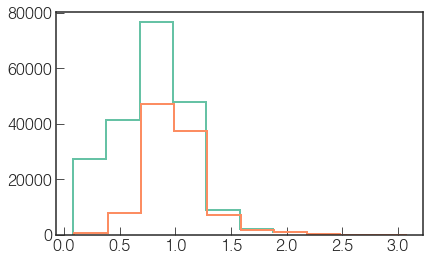

In [154]:
plt.hist(np.r_[q.mass,q.compMass], histtype='step', lw=2 )
plt.hist(q.mass, histtype='step', lw=2 )

In [155]:
z = q.transit_depth_undiluted / (1 + 10**((Mr_primary - Mr_companion ) / -2.5)) #bins=np.arange(1,3.,0.1))

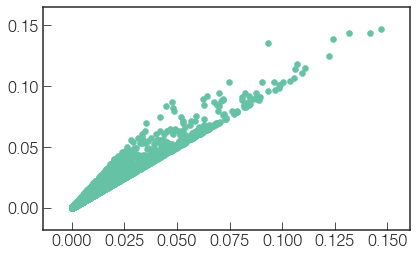

In [156]:
_ = plt.scatter(z, q.transit_depth_undiluted)

In [157]:
[np.argmax(q.transit_depth_undiluted)]

[121450]

In [158]:
np.where((q.stype == 'M') | ((q.compMass <=0.55) & q.isBinary), mdwarfplanets, otherplanets )

array([[  2.70788456,   2.49677235,   1.30117671, ...,   2.32884208,
          1.13498456,   1.75998081],
       [ 69.42617805,  16.2895557 ,  12.75792869, ...,   7.07618195,
         15.5694539 ,   5.94267915]])

In [159]:
q.isBinary[169268]

False

In [160]:
q.orbitsPrimary[169268]

True

(0, 20)

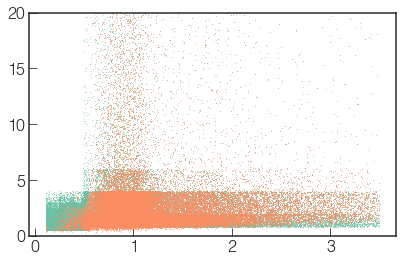

In [161]:
plt.scatter(q.hostRadius, q.planetRadius, s=0.1)
plt.scatter(q.st_radius[detected_diluted], 
            np.sqrt(q.transit_depth_diluted[detected_diluted]) * 
            q.st_radius[detected_diluted] / 0.009155, s=0.1)
plt.ylim(0,20)

(0, 20)

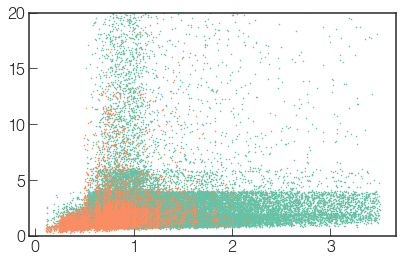

In [162]:
plt.scatter(q.hostRadius[detected_diluted & q.orbitsPrimary], 
            np.sqrt(q.transit_depth_diluted[detected_diluted& q.orbitsPrimary]) * 
            q.st_radius[detected_diluted& q.orbitsPrimary] / 0.009155,
            s=1)

plt.scatter(q.hostRadius[detected_diluted & ~q.orbitsPrimary], 
            np.sqrt(q.transit_depth_diluted[detected_diluted& ~q.orbitsPrimary]) * 
            q.st_radius[detected_diluted& ~q.orbitsPrimary] / 0.009155,
            s=1)
plt.ylim(0,20)

In [163]:
print(q.transit_depth_diluted[detected_diluted& ~q.orbitsPrimary].shape[0])
print(q.transit_depth_diluted[detected_diluted& q.orbitsPrimary & q.isBinary].shape[0])
print(q.transit_depth_diluted[detected_diluted& q.orbitsPrimary & ~q.isBinary].shape[0])

8679
18322
40437


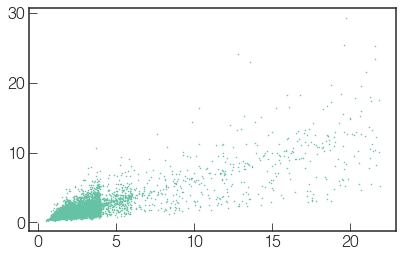

In [165]:
plt.scatter(q.planetRadius[detected_diluted& ~q.orbitsPrimary] , 
            np.sqrt(q.transit_depth_diluted[detected_diluted& ~q.orbitsPrimary]) * 
            q.st_radius[detected_diluted& ~q.orbitsPrimary] / 0.009155, s=1)

In [166]:
np.argmax(np.sqrt(q.transit_depth_diluted) * 
            q.st_radius / 0.009155)

73312

In [167]:
np.sqrt(q.transit_depth_diluted.ix[45535]) *q.st_radius.ix[45535] / 0.009155

3.626812878217565

In [168]:
print(Mr_primary.shape, Mr_companion.shape)
print(q.transit_depth_diluted.shape)
print(q.planetRadius.shape)

(102997,) (102997,)
(102997,)
(102997,)


(0, 20)

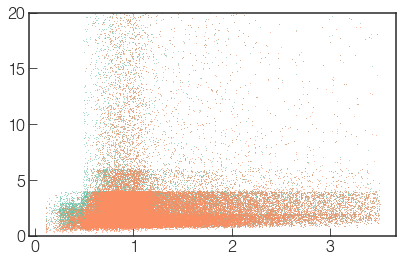

In [169]:
plt.scatter(q.hostRadius[detected_diluted], q.planetRadius[detected_diluted], s=0.1)
plt.scatter(q.st_radius[detected_diluted], 
            np.sqrt(q.transit_depth_diluted[detected_diluted]) * 
            q.st_radius[detected_diluted] / 0.009155, s=0.1)
plt.ylim(0,20)


In [170]:
print(0.1**0.5 * 0.1 / 0.009155)
print(0.005**0.5 * 3.0 / 0.009155)

3.454153643
23.1711670514


In [181]:
rs1 = 1.0
rs2 = np.arange(0.1,1.1,0.01)

rp1 = 4.0

td1 = (rp1*0.009155 / rs2)**2

mag1 = np.interp(1.0,
                       mamajekRadius[::-1], mamajek.loc[:,'Mr'][m][::-1], np.nan, np.nan)
mag2 = np.interp(rs2,
                       mamajekRadius[::-1], mamajek.loc[:,'Mr'][m][::-1], np.nan, np.nan)


td2 = td1 /(1+(10**((mag2 - mag1) / -2.5)))

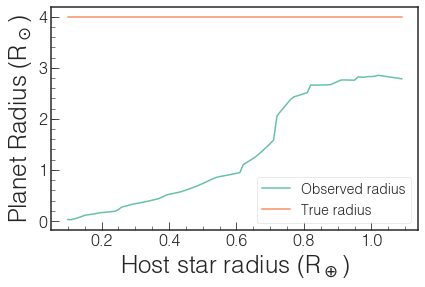

In [182]:
plt.plot(rs2,td2**0.5 * rs1 / 0.009155, label='Observed radius')
plt.plot(rs2,td1**0.5 * rs2 / 0.009155, label='True radius')

plt.xlabel('Host star radius (R$_\oplus$)')
plt.ylabel('Planet Radius (R$_\odot$)')
plt.legend()
plt.minorticks_on()

In [183]:
td2**0.5 / 0.009155

array([ 0.0269587 ,  0.02524481,  0.04156132,  0.06217112,  0.08462411,
        0.11202538,  0.1204085 ,  0.12992635,  0.14068319,  0.15280199,
        0.16397776,  0.16974574,  0.17611578,  0.18310293,  0.19072754,
        0.22377412,  0.2728759 ,  0.28894449,  0.30637746,  0.3252744 ,
        0.33788777,  0.34984273,  0.36259555,  0.37617772,  0.39062391,
        0.40597197,  0.42226291,  0.43967964,  0.46904289,  0.50069722,
        0.52149674,  0.534686  ,  0.54852699,  0.56303621,  0.58169651,
        0.60434759,  0.62816942,  0.6517271 ,  0.67702361,  0.70459601,
        0.73355649,  0.76396551,  0.79588546,  0.82727661,  0.85146141,
        0.86888162,  0.88085846,  0.89325753,  0.90608008,  0.91932768,
        0.93300212,  0.94710536,  1.10432651,  1.14367855,  1.18452513,
        1.2268945 ,  1.27484966,  1.33155826,  1.39060241,  1.45199977,
        1.51575277,  1.5818459 ,  2.05248151,  2.13972968,  2.21888198,
        2.29810734,  2.37808527,  2.42927829,  2.45060148,  2.47

In [186]:
rs1 = 1.0
rs2 = 0.2

rp1 = np.arange(0.5,10.0,0.5)

td1 = (rp1*0.009155 / rs2)**2

mag1 = np.interp(1.0,
                       mamajekRadius[::-1], mamajek.loc[:,'Mr'][m][::-1], np.nan, np.nan)
mag2 = np.interp(rs2,
                       mamajekRadius[::-1], mamajek.loc[:,'Mr'][m][::-1], np.nan, np.nan)


td2 = td1 /(1+10**((mag2 - mag1) / -2.5))

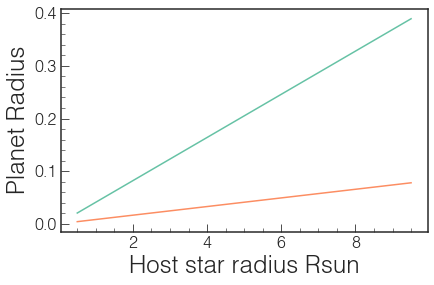

In [187]:
plt.plot(rp1,td2**0.5 * rs1 / 0.009155)
plt.plot(rp1,td2**0.5 * rs2 / 0.009155)
plt.xlabel('Host star radius Rsun')
plt.ylabel('Planet Radius')
plt.legend()
plt.minorticks_on()

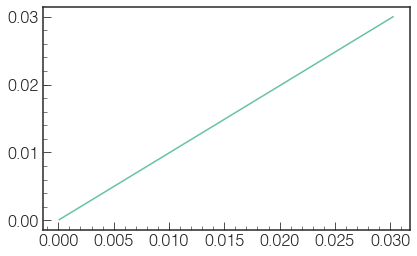

In [180]:
plt.plot(td1,td2)
plt.legend()
plt.minorticks_on()

In [93]:
np.interp([0.2,0.5, 1.0], mamajekRadius[::-1], mamajek.loc[:,'Mr'][m][::-1], np.nan, np.nan)

array([-15.69571034, -10.44367291,  -5.26455814])

In [100]:
td2**0.5

array([ 0.36619992,  0.33290901,  0.30516643,  0.28169173,  0.26157028,
        0.24413118,  0.22887235,  0.21540848,  0.20344037,  0.19273177,
        0.18309385,  0.17437403,  0.16644674,  0.15920857,  0.15257334,
        0.14646567,  0.140824  ,  0.13560383,  0.13075563,  0.12624074,
        0.12202747,  0.11808561,  0.11438934,  0.11091624,  0.1076465 ,
        0.10456254,  0.10164874,  0.09889108,  0.0962727 ,  0.09378548,
        0.09142543,  0.08918283,  0.08704574,  0.08500665,  0.08305672,
        0.08118947,  0.0794007 ,  0.0776861 ,  0.07603947,  0.07445579,
        0.07293145,  0.07146248,  0.07004512,  0.06867799,  0.06736531,
        0.06610494,  0.06489371,  0.06372302,  0.06259064,  0.06149451,
        0.06043268,  0.05940331,  0.05819281,  0.0571762 ,  0.05618172,
        0.05520742,  0.05424344,  0.05327993,  0.05232649,  0.05138075,
        0.05044027,  0.04950265,  0.04726279,  0.04618146,  0.04512493,
        0.04406128,  0.04298518,  0.04203791,  0.04124126,  0.04

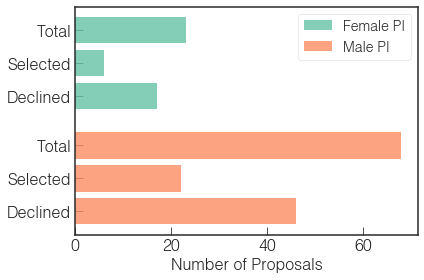

In [218]:
men = [68,22,68-22]
women = [23,6,23-6]
opacity=0.8

plt.barh([5.5,4.5,3.5], women, label='Female PI', alpha=opacity)
plt.barh([2,1,0], men, label='Male PI', alpha=opacity)
plt.legend()

plt.yticks([0,1,2,3.5,4.5,5.5], ('Declined', 'Selected', 'Total', 'Declined', 'Selected', 'Total'))
plt.xlabel('Number of Proposals', fontsize=16)
plt.tight_layout()
plt.savefig('/Users/tom/Dropbox/Campaign14_15_16/pi-gender.png', dpi=150)